# 

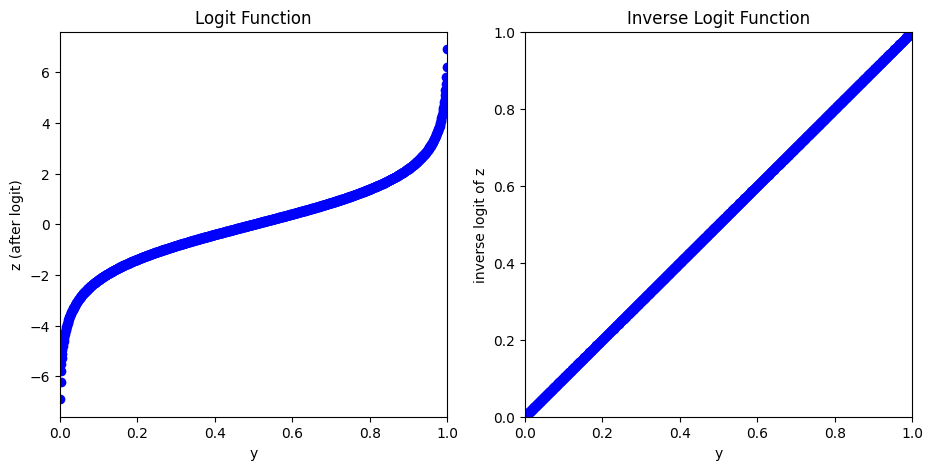

In [1]:
# 03_03_logit

import matplotlib.pyplot as plt
import numpy as np

values = np.arange(0.001, 1, 0.001, dtype=float)
logit = np.log(values / (1 - values))
inverse_logit = np.exp(logit) / (1 + np.exp(logit))

fig, ax = plt.subplots(1, 2, squeeze=False, figsize=(11, 5))

fig1 = ax[0, 0]
fig1.scatter(values, logit, c="blue")
fig1.set_xlabel("y")
fig1.set_ylabel("z (after logit)")
fig1.set_xlim(0, 1)
fig1.set_title("Logit Function")

fig2 = ax[0, 1]
fig2.scatter(values, inverse_logit, c="blue")
fig2.set_xlabel("y")
fig2.set_ylabel("inverse logit of z")
fig2.set_xlim(0, 1)
fig2.set_ylim(0, 1)
fig2.set_title("Inverse Logit Function")
plt.show()


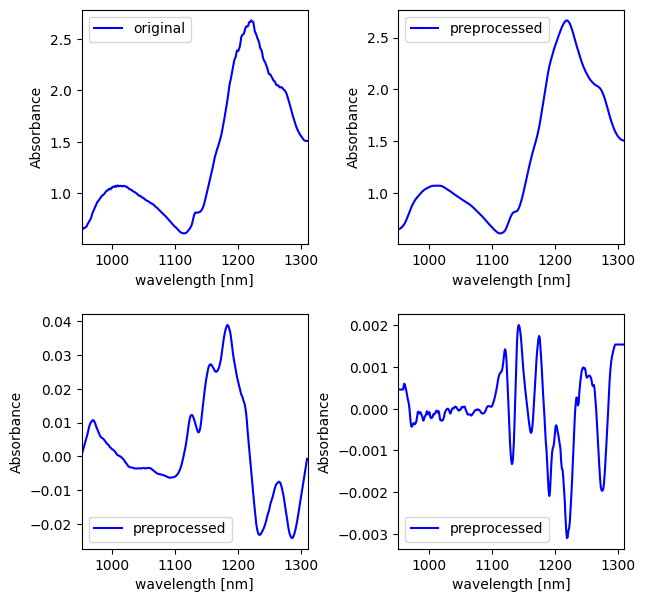

In [2]:
# 03_04_sg

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.signal import savgol_filter

# SG法の設定値
window_length = 21  # 窓枠の数
poly_order = 2  # 多項式の次数
deriv = 0  # 微分次数 (0 は微分なし)
plot_spectra_number = 12  # 表示するスペクトルのサンプル番号 (0, 1, ..., 227)

csv_path = Path("dataset/sample_spectra_dataset.csv")
preprocessed_csv_path0 = Path(
    f"dataset/preprocessed_sample_spectra_dataset_w{window_length}_p{poly_order}_d{deriv}.csv"
)
preprocessed_csv_path1 = Path(
    f"dataset/preprocessed_sample_spectra_dataset_w{window_length}_p{poly_order}_d{1}.csv"
)
preprocessed_csv_path2 = Path(
    f"dataset/preprocessed_sample_spectra_dataset_w{window_length}_p{poly_order}_d{2}.csv"
)

# データセットの読み込み
x = pl.read_csv(csv_path).drop("")
# SG 法
preprocessed_x0 = savgol_filter(
    x.to_numpy(), window_length=window_length, polyorder=poly_order, deriv=deriv
)
preprocessed_x1 = savgol_filter(
    x.to_numpy(), window_length=window_length, polyorder=poly_order, deriv=1
)
preprocessed_x2 = savgol_filter(
    x.to_numpy(), window_length=window_length, polyorder=poly_order, deriv=2
)
# pl.DataFrameに変換してcsvとして保存
preprocessed_x0 = pl.DataFrame(preprocessed_x0, schema=x.schema)
preprocessed_x1 = pl.DataFrame(preprocessed_x1, schema=x.schema)
preprocessed_x2 = pl.DataFrame(preprocessed_x2, schema=x.schema)
preprocessed_x0.with_row_index("").write_csv(preprocessed_csv_path0)
preprocessed_x1.with_row_index("").write_csv(preprocessed_csv_path1)
preprocessed_x2.with_row_index("").write_csv(preprocessed_csv_path2)

# プロット
fig, ax = plt.subplots(2, 2, squeeze=False, figsize=(7, 7))
wave_lengths = np.array(x.columns, dtype="float64")
fig1 = ax[0, 0]
fig1.plot(wave_lengths, x.row(plot_spectra_number), "b-", label="original")
fig1.set_xlabel("wavelength [nm]")
fig1.set_ylabel("Absorbance")
fig1.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig1.legend()

fig2 = ax[0, 1]
fig2.plot(
    wave_lengths,
    preprocessed_x0.row(plot_spectra_number),
    "b-",
    label="preprocessed",
)
fig2.set_xlabel("wavelength [nm]")
fig2.set_ylabel("Absorbance")
fig2.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig2.legend()

fig3 = ax[1, 0]
fig3.plot(
    wave_lengths,
    preprocessed_x1.row(plot_spectra_number),
    "b-",
    label="preprocessed",
)
fig3.set_xlabel("wavelength [nm]")
fig3.set_ylabel("Absorbance")
fig3.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig3.legend()

fig4 = ax[1, 1]
fig4.plot(
    wave_lengths,
    preprocessed_x2.row(plot_spectra_number),
    "b-",
    label="preprocessed",
)
fig4.set_xlabel("wavelength [nm]")
fig4.set_ylabel("Absorbance")
fig4.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig4.legend()

plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()


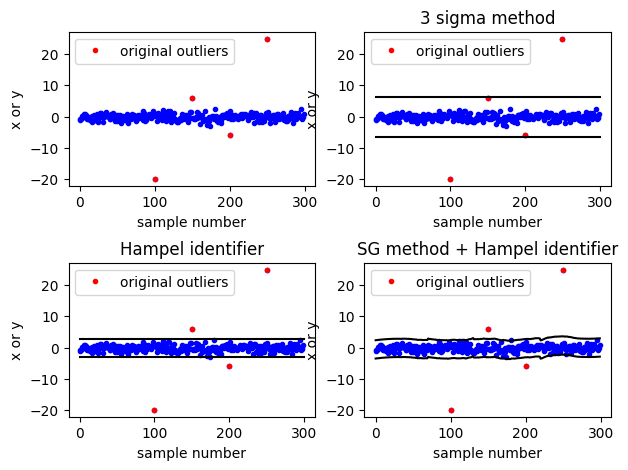

In [12]:
# 03_05_outlier

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# 設定 ここから
type_of_samples = 0  # 仮想サンプルの種類 0:正規乱数、1:時系列
window_length = 61  # SG 法における窓枠の数
poly_order = 2  # SG 法における多項式の次数
deriv = 0  # SG 法における微分次数 (0 は微分なし)
number_of_samples = 300  # 仮想サンプルの数
noise_rate = 8  # SN比

rng = np.random.default_rng(seed=10)

if type_of_samples == 0:
    outliers = [-20, 6, -6, 25]  # 外れ値
    outlier_indexes = [100, 150, 200, 250]  # 外れ値のインデックス
    x = rng.standard_normal(number_of_samples)
elif type_of_samples == 1:
    outliers = [1, 3, 10, -2]  # %外れ値
    outlier_indexes = [80, 150, 200, 250]  # 外れ値のインデックス
    x = np.sin(np.arange(number_of_samples) * np.pi / 50)
    noise = rng.standard_normal(number_of_samples)
    noise = noise * (x.var() / noise_rate) ** 0.5
    x += noise
x[outlier_indexes] = outliers  # 外れ値の追加

fig, ax = plt.subplots(2, 2, squeeze=False, figsize=(7, 5))

fig1 = ax[0, 0]
fig1.plot(x, "b.")  # プロット
fig1.plot(
    outlier_indexes, x[outlier_indexes], "r.", label="original outliers"
)  # プロット
fig1.set_xlabel("sample number")  # x 軸の名前
fig1.set_ylabel("x or y")  # y 軸の名前
fig1.legend()


# 3 sigma method
upper_3_sigma = x.mean() + 3 * x.std()
lower_3_sigma = x.mean() - 3 * x.std()
fig2 = ax[0, 1]
fig2.plot(x, "b.")
fig2.plot(outlier_indexes, x[outlier_indexes], "r.", label="original outliers")
fig2.plot([0, len(x)], [upper_3_sigma, upper_3_sigma], "k-")
fig2.plot([0, len(x)], [lower_3_sigma, lower_3_sigma], "k-")
fig2.set_xlabel("sample number")  # x 軸の名前
fig2.set_ylabel("x or y")  # y 軸の名前
fig2.set_title("3 sigma method")
fig2.legend()

# Hampel identifier
upper_hampel = np.median(x) + 3 * 1.4826 * np.median(np.absolute(x - np.median(x)))
lower_hampel = np.median(x) - 3 * 1.4826 * np.median(np.absolute(x - np.median(x)))
fig3 = ax[1, 0]
fig3.plot(x, "b.")
fig3.plot(outlier_indexes, x[outlier_indexes], "r.", label="original outliers")
fig3.plot([0, len(x)], [upper_hampel, upper_hampel], "k-")
fig3.plot([0, len(x)], [lower_hampel, lower_hampel], "k-")
fig3.set_xlabel("sample number")  # x 軸の名前
fig3.set_ylabel("x or y")  # y 軸の名前
fig3.set_title("Hampel identifier")
fig3.legend()

# SG method + Hampel identifier
preprocessed_x = savgol_filter(
    x, window_length=window_length, polyorder=poly_order, deriv=deriv
)  # SG 法
x_diff = x - preprocessed_x
upper_sg_hampel = (
    preprocessed_x
    + np.median(x_diff)
    + 3 * 1.4826 * np.median(np.absolute(x_diff - np.median(x_diff)))
)
lower_sg_hampel = (
    preprocessed_x
    + np.median(x_diff)
    - 3 * 1.4826 * np.median(np.absolute(x_diff - np.median(x_diff)))
)
fig4 = ax[1, 1]
fig4.plot(x, "b.")
fig4.plot(outlier_indexes, x[outlier_indexes], "r.", label="original outliers")
fig4.plot(range(len(x)), upper_sg_hampel, "k-")
fig4.plot(range(len(x)), lower_sg_hampel, "k-")
fig4.set_xlabel("sample number")  # x 軸の名前
fig4.set_ylabel("x or y")  # y 軸の名前
fig4.set_title("SG method + Hampel identifier")
fig4.legend()

plt.subplots_adjust(hspace=0.5)
plt.show()  # 以上の設定で描画


In [2]:
# 03_06 demo_elo_pls

import numpy as np
import polars as pl
from dcekit.learning import ensemble_outlier_sample_detection
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, KFold

# Demonstration of Ensemble Learning Outlier sample detection (ELO)
# https://datachemeng.com/ensembleoutliersampledetection/
# https://www.sciencedirect.com/science/article/abs/pii/S0169743917305919

dataset = pl.read_csv("dataset/numerical_simulation_data.csv").drop("")
y = dataset.get_column("y").to_numpy()
x = dataset.drop("y").to_numpy()

# PLS
max_pls_component_number = 30
pls_components = np.arange(1, min(max_pls_component_number, x.shape[1]) + 1)
cross_validation = KFold(n_splits=2, random_state=9, shuffle=True)
cv_regressor = GridSearchCV(
    PLSRegression(), {"n_components": pls_components}, cv=cross_validation
)
number_of_sub_models = 100
max_iteration_number = 30
outlier_sample_flags = ensemble_outlier_sample_detection(
    cv_regressor,
    x,
    y,
    cv_flag=True,
    n_estimators=number_of_sub_models,
    iteration=max_iteration_number,
    autoscaling_flag=True,
    random_state=0,
)

outlier_sample_flags = pl.DataFrame(outlier_sample_flags)
outlier_sample_flags.columns = ["TRUE if outlier samples"]
outlier_sample_flags.write_csv("dataset/outlier_sample_detection_results.csv")


1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30


In [9]:
# 03_07 欠損値の補完(iGMR)

import polars as pl
from dcekit.generative_model import GMR


def calc_interpolated_values(
    model: GMR,
    x_row: list[float],
    normalized_x_row: list[float],
    x: pl.DataFrame,
) -> list[float]:
    """補完値の計算と挿入."""
    if None not in x_row:
        return x_row
    row_series = pl.Series(x_row)
    normalized_row_series = pl.Series(normalized_x_row)
    is_null_series = row_series.is_null()
    is_val_series = row_series.is_not_null()
    mode_of_estimated_mean, *_ = model.predict(
        normalized_row_series.filter(is_val_series).to_frame().transpose(),
        is_val_series.arg_true(),
        is_null_series.arg_true(),
    )

    interpolated_vals = pl.Series(mode_of_estimated_mean[0]) * pl.Series(
        x.std().row(0)
    ).filter(is_null_series) + pl.Series(x.mean().row(0)).filter(is_null_series)

    # Noneをinterpolated_valueに置換
    # for i, j in enumerate(is_null_series.arg_true()):
    return row_series.scatter(is_null_series.arg_true(), interpolated_vals).to_list()


# load dataset
x_wt_nulls = pl.read_csv("dataset/iris_with_nan.csv").drop("")
x = x_wt_nulls.drop_nulls()
# 正規化
normalized_x_wt_nulls = (
    x_wt_nulls
    - x.mean().select(pl.all().extend_constant(pl.all(), n=x_wt_nulls.height - 1))
) / x.std().select(pl.all().extend_constant(pl.all(), n=x_wt_nulls.height - 1))
normalized_x = (
    x - x.mean().select(pl.all().extend_constant(pl.all(), n=x.height - 1))
) / x.std().select(pl.all().extend_constant(pl.all(), n=x.height - 1))
# 元/正規化データのrowデータ(リスト)のDataFrameを作成
rows_of_ori_and_normalized_x_df = x_wt_nulls.select(
    pl.concat_list(pl.all()).alias("x_row")
).hstack(
    normalized_x_wt_nulls.select(pl.concat_list(pl.all()).alias("normalized_x_row"))
)

max_num_of_compo = 20
covariance_types = ["full", "diag", "tied", "spherical"]
for iteration in range(iterations := 10):
    print(f"iteration: {iteration + 1} / {iterations}")
    # グリッドサーチで最適(BICが一番小さい)パラメータを取得.
    bic_values = pl.DataFrame(
        {
            "num_of_compo": [
                num_of_compo
                for _ in covariance_types
                for num_of_compo in range(max_num_of_compo)
            ],
            "cov_type": [
                cov_type
                for cov_type in covariance_types
                for _ in range(max_num_of_compo)
            ],
            "BIC": [
                GMR(num_of_compo + 1, cov_type, random_state=0)
                .fit(normalized_x)
                .bic(normalized_x)
                for cov_type in covariance_types
                for num_of_compo in range(max_num_of_compo)
            ],
        }
    ).sort(pl.col("BIC"))

    # GMM
    model = GMR(
        n_components=bic_values.item(0, "num_of_compo") + 1,
        covariance_type=bic_values.item(0, "cov_type"),
        random_state=0,
    )
    model.fit(normalized_x)

    # interpolation(補完).
    x = (
        rows_of_ori_and_normalized_x_df.select(
            pl.struct(pl.col("x_row"), pl.col("normalized_x_row"))
            .map_elements(
                lambda row_dict, model=model, x=x: calc_interpolated_values(
                    model,
                    row_dict["x_row"],
                    row_dict["normalized_x_row"],
                    x,
                )
            )
            .alias("x_row")
        )
        .with_columns(pl.col("x_row").list.to_struct(fields=x.columns))
        .unnest("x_row")
    )

    # 正規化データを更新
    normalized_x = (
        x - x.mean().select(pl.all().extend_constant(pl.all(), n=x.height - 1))
    ) / x.std().select(pl.all().extend_constant(pl.all(), n=x.height - 1))
    # 元/正規化データのrowデータ(リスト)のDataFrameを更新
    next_normalized_x_rows = normalized_x.select(
        pl.concat_list(pl.all()).alias("normalized_x_row")
    ).get_column("normalized_x_row")
    rows_of_ori_and_normalized_x_df.replace_column(1, next_normalized_x_rows)

# save interpolated dataset
x.with_row_index("").with_columns(
    (pl.lit("sample_") + pl.col("").add(1).cast(pl.String)).alias("")
).write_csv("dataset/interpolated_dataset.csv")

iteration: 1 / 10
iteration: 2 / 10
iteration: 3 / 10
iteration: 4 / 10
iteration: 5 / 10
iteration: 6 / 10
iteration: 7 / 10
iteration: 8 / 10
iteration: 9 / 10
iteration: 10 / 10


In [ ]:
import numpy as np
import polars as pl

# 同じ値をもつサンプルの割合で特徴量を削除するためのしきい値
threshold_duplicate_value_rate = 0.8

dataset = pl.read_csv("dataset/descriptors_with_logS.csv").drop("")

y = dataset.select("logS")  # 目的変数
x = dataset.select(pl.exclude("logS"))  # 説明変数

print("最初の特徴量の数 :", x.width)
# 同じ値の割合が、threshold_duplicate_value_rate 以上の特徴量を削除
dup_val_rates = (
    x.select(
        pl.all()
        .value_counts(sort=True, normalize=True, name="dup_rate")
        .first()
        .struct.field("dup_rate")
        .name.keep()
    )
    .with_columns(pl.all() >= threshold_duplicate_value_rate)
    .row(0)
)
x_selected = x[:, dup_val_rates]
print("削除後の特徴量の数 :", x_selected.width)

x_selected.write_csv("dataset/x_selected_same_value2.csv")  # 保存


最初の特徴量の数 : 200
削除後の特徴量の数 : 98
